Replicating a ml research paper and creating a VIsion Transformer (vit) fomr scratch using PyTorch

## What is paper replicating?

The goal of paper replicating is to replicate ml advances with code so you can use the techniques fro your own problem.

ML research paper replicating involves turning a ML paper comprised of images/diagrams, math and text into usable code.

## What is a ML research paper?

A machine learning research paper is a scientific paper that details findings of a research group on a specific area.



## Why replicate a ML research paper?

A ML research paper is often a presentation of months of work and experiments done by some of the best ML teams in the world consdensed into a few pages of text. And if theses experiments lead to better results in an area related to the problem you are working on, it'd be nice to check them out.

## Where can you find code exapmle fo ML research papers?

1. arXiv https://arxiv.org/
2. AK Twitter https://twitter.com/_akhaliq
3. Papers with Code https://paperswithcode.com/

## What we are going to cover

A Transformer architecture is generally considered to be any nn that uses the attention mechanism as its primary learning layer. Similar to how a cnn uses convolutions as its primary learning layer.

Like the name suggests, hte Vision Transformer (Vit) architecture was designed to adapt the original Transformer architecture to vision problmes.

We are going to replicate the "vanilla Vision Transformer" becaue from the base version we can then adopt other versions.

## Terminology

* Vit - Stands for Vision Transformer
* Vit paper - Short hand for the ogirinal ml research paper that introducted Vit Archtiecture(https://arxiv.org/abs/2010.11929)


## 0. Getting setup

In [1]:
import torch
import torchvision

print(f"torch version: {torch.__version__}")
print(f"torchvision version: {torchvision.__version__}")

torch version: 2.1.0+cu118
torchvision version: 0.16.0+cu118


Now we'll going to import the helper fucntions and going_modular that we made in previous notebooks

In [2]:
# Contrinou with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install if you do not have it
try:
  from torchinfo import summary
except:
  print(f"torchinfo not found...")
  !pip install -q torchinfo
  from torchinfo import summary
  print(f"torchinfo installed :)")

In [3]:
# Try to import the going_modular dir
try:
  from going_modular.going_modular import data_setup, engine
  from helepr_functions import download_data, plot_loss_curves
except:
  print(f"Could not find going modular or helper_functions...")
  !git clone https://github.com/mrdbourke/pytorch-deep-learning
  !mv pytorch-deep-learning/going_modular . # get the going_modular.py script (!mv move or rename)
  !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script (!mv move or rename)
  !rm -rf pytorch-deep-learning # removes the dict
  from going_modular.going_modular import data_setup, engine
  from helper_functions import download_data, set_seeds, plot_loss_curves

Could not find going modular or helper_functions...
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4036, done.
remote: Counting objects: 100% (1224/1224), done.
remote: Compressing objects: 100% (225/225), done.
remote: Total 4036 (delta 1068), reused 1078 (delta 996), pack-reused 2812
Receiving objects: 100% (4036/4036), 651.02 MiB | 15.35 MiB/s, done.
Resolving deltas: 100% (2361/2361), done.
Updating files: 100% (248/248), done.
mv: cannot move 'pytorch-deep-learning/going_modular' to './going_modular': Directory not empty


In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 1. Get Data



In [5]:
# Download data from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")

image_path

[INFO] data/pizza_steak_sushi directory exists, skipping download.


PosixPath('data/pizza_steak_sushi')

In [6]:
# Setup dir paths
train_dir = image_path / "train"
test_dir = image_path / "test"


## 2 Createa Datasets and DataLoaders

From Table 3 in the Vit paper we can see that the Batch size for traiing the model was 4096 and the image size was 224x224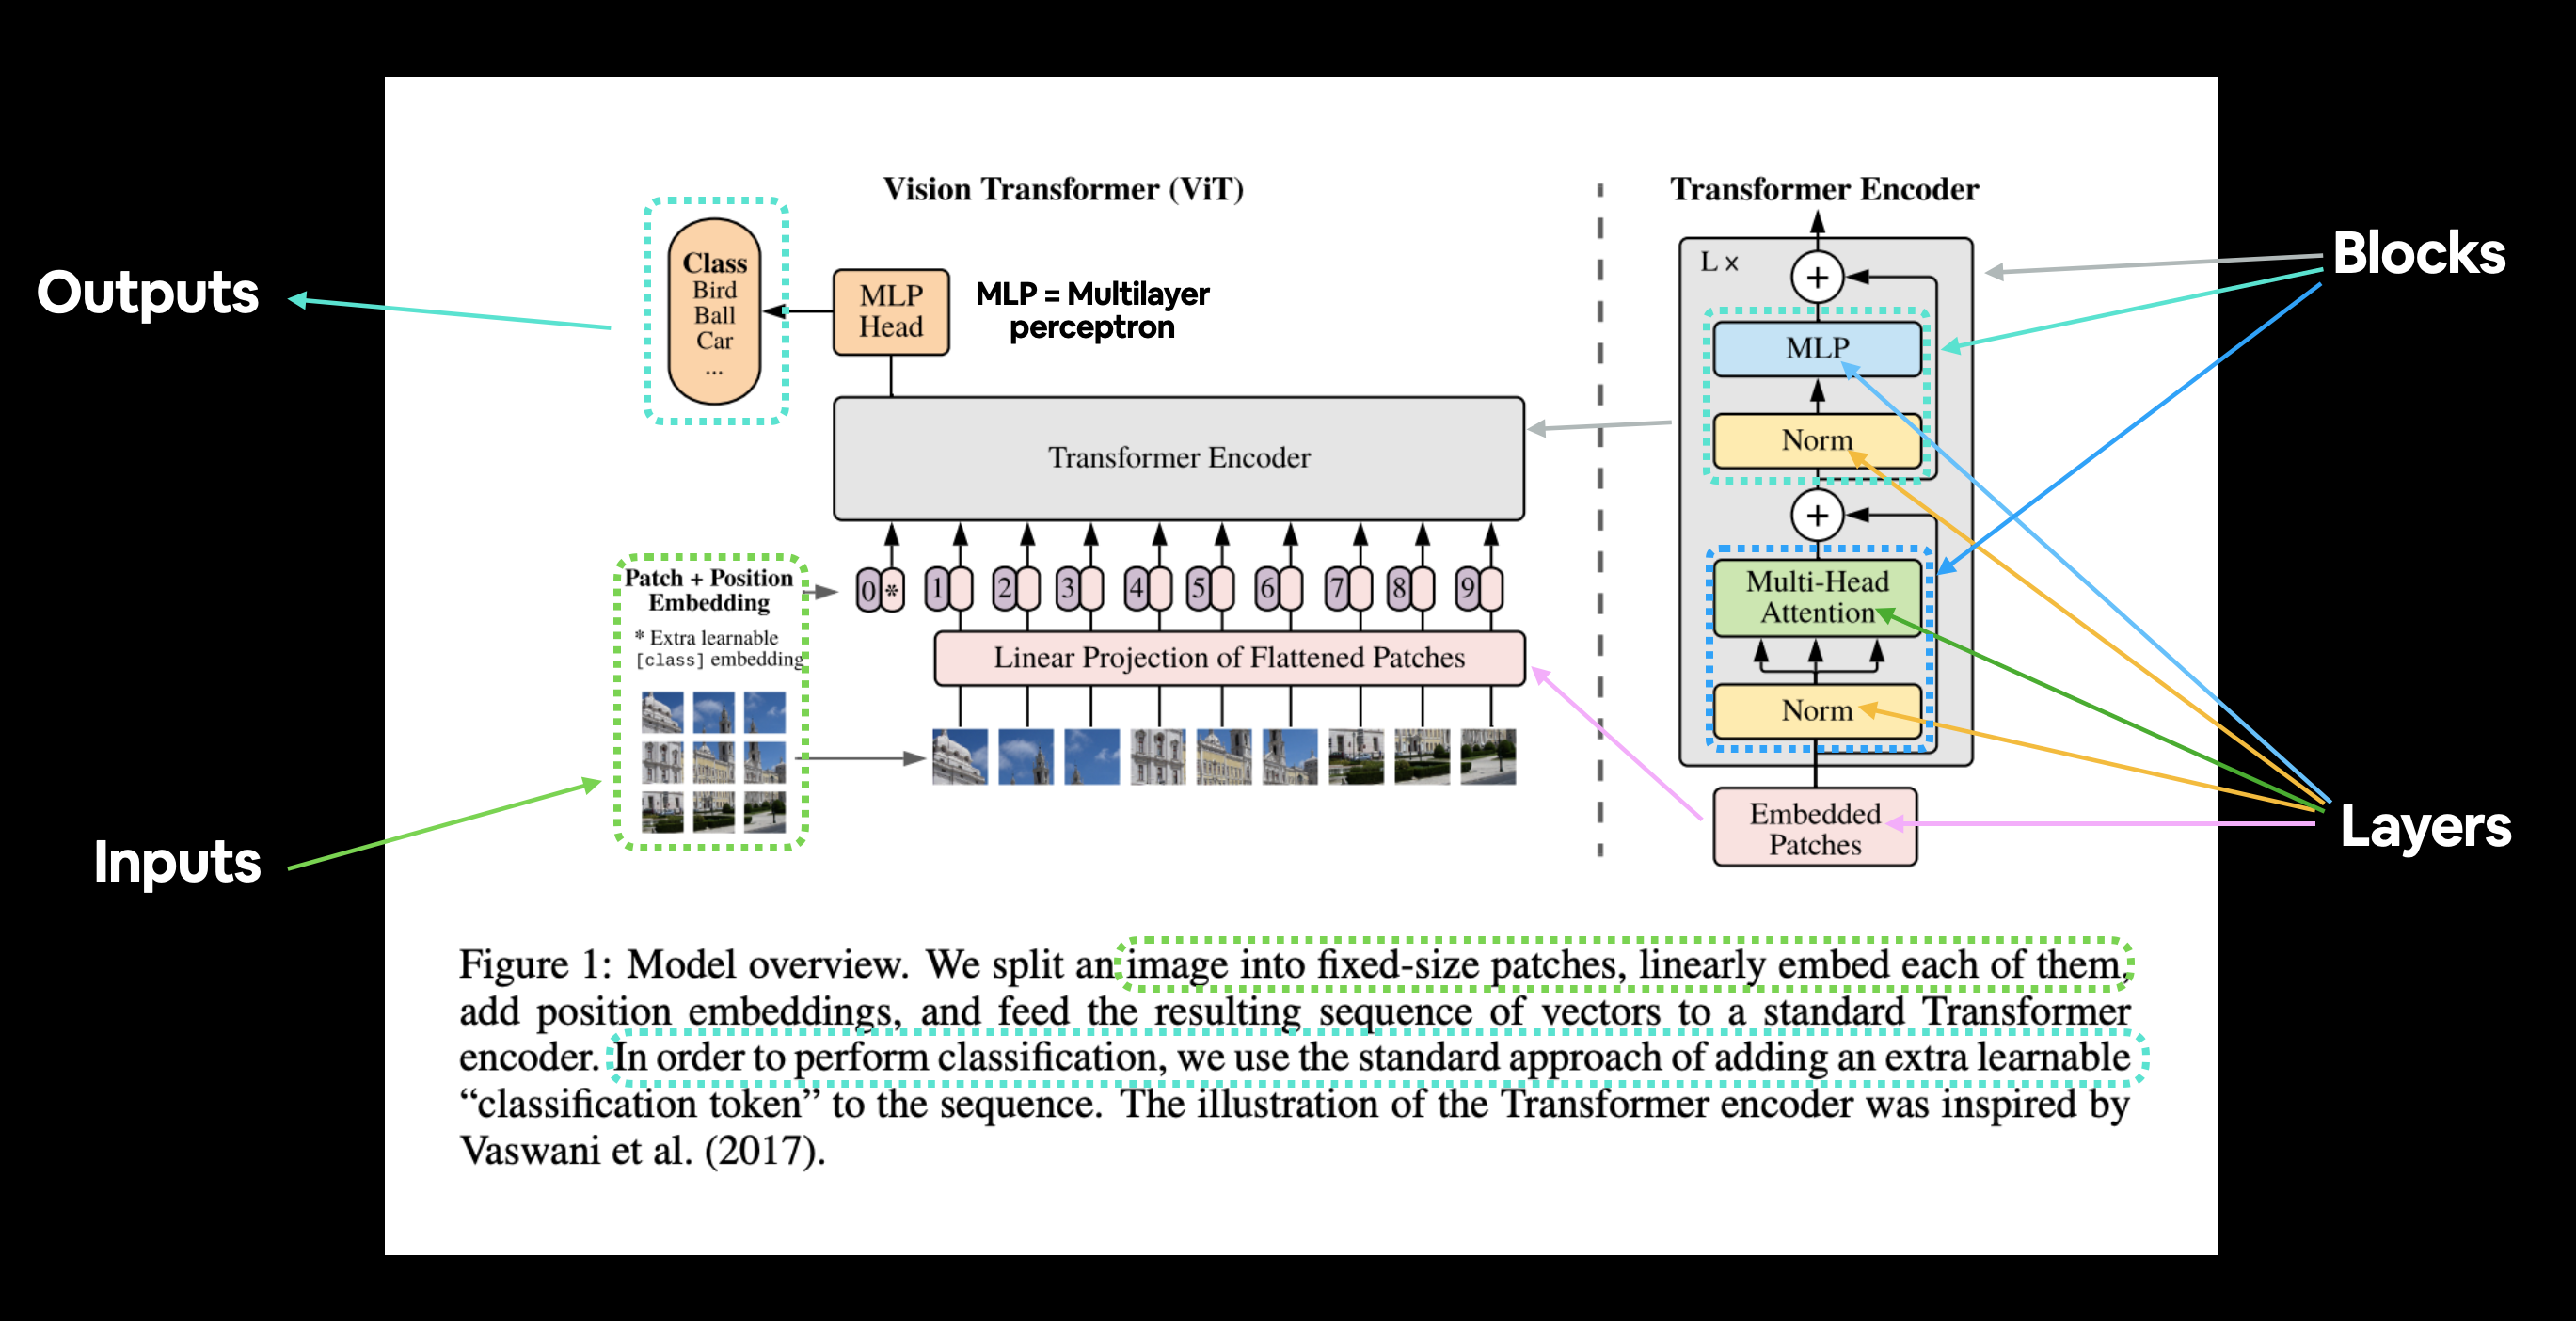

### 2.1 Prepare transfomrs for images

In [7]:
# Create iamge size
IMG_SIZE = 224

# Create transfomr pipeline manually
manual_transforms = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE,IMG_SIZE)),
        transforms.ToTensor()
    ]
)
print(f"Manual transfomrs: {manual_transforms}")

Manual transfomrs: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
)


### 2.2 Trun images into `DataLoaders`

ALtough in the paper the BATCH_SIZE was 4096 we are going to use BATCH_SIZE = 32 becasue we do not have a gpu that can handle 4096 images fitting into one GPU memory at a time.

In [8]:
# set up batch size
BATCH_SIZE = 32

# Create data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7cc2313e38b0>,
 ['pizza', 'steak', 'sushi'])

### 2.3 Visualize a single image

In [9]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a songle ioamge from the abtch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(0))

(-0.5, 223.5, 223.5, -0.5)

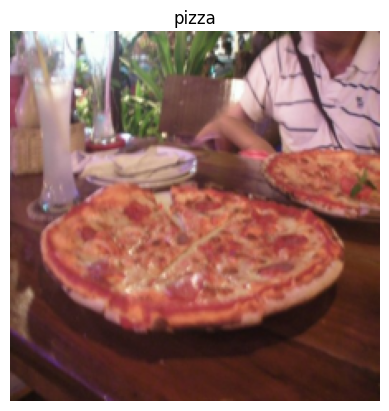

In [10]:
# Plot image with matplotlib
plt.imshow(image.permute(1,2,0)) # matplotlib likes C last cuz its build on np
plt.title(class_names[label])
plt.axis(False)

## 3. Replicating the Vit paper: an overview

Our **model inputs**: images of pizza, steak and sushi

Our **model outputs**: predicted lables of pizza, steak or sushi

### 3.1 Inputs and outputs, layers and blocks

Vit is a deep learning nn architecture.

Any nn architecture is comprised of **layers**.

A collection of layers is often referred to as a **block**.

A **layer** takes an input(say image tensor), performs some kind of function on it and the nreturns an output.

So if a **single layer** tkaes an input and gives and output, then a collection of layers of a **block** also takes an input and gives an output.

Sooo we are going to takie it layer by layer, block by block, function by function putting the pieces of the puzzle together.



### 3.2 Getting specific: What's Vit made of?

The 3 main resources we'll be looking at for the architecture design are:
1. **Figure 1** - this gives an overview of the model in a graphical sense, you could alomst recreate the architecture with this figure ealone.
2. **Four equations in section 3.1** - Thses equations give a little bit more of a mathematical grounding to the colorud blocks in Figure 1.
3. **Table 1** - This tables hsopws the various hyperparameters settgins(such as number of layers and anumber of hidden units) for different Vit model variants


#### 3.2.1 Exploring Figure 1

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-figure-1-architecture-overview.png" width=1000 alt="figure 1 from vision transformer paper"/>

The main things we'll be paying attention to are:
1. **Layers** - takes an input, perfomrs an operation or function on the input, produces an output
2. **Blocks** - a collection of layers, which in turn also takes an **input** and produces an **output*

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-figure-1-inputs-and-outputs-food-mini.png" width=1000 alt="figure 1 from vision transformer paper"/>

The Vit architecture is copirsed of severla stages:
* Patch + Position Embedding(inputs) - Turns the input image into a sequence of images patchs and adds a postion number to specify in what order the patch comes in.
* Linear projection of flattend patches(Embedded Patches)  - The image patches get turned into an embedding, the benefit of using an embedding rather than just the image values is that an embedding is learnable repsenatation(vector) of the image that can improve with training.
* Norm - This is short for Layer Normalization, a technique for regularizationg a nn
* Multi-Head Attention - This is a multi-head self-attention layers
* MLP - a MLP can often refer to any collection of feedforward layers. In the Vit paper the authors refer ot the MLP as the "MLP block" and it contains two nn.Linear layers with a nn.GELU() non-linear activation in between and a nn.Dropout() layers
* Transformere Encode - The transfomrer Encoder, is a colleciton of layers listed above. There are two skip connections inside the Transformeer encoded(the + sumbols) meaning the layer's inputs are fed directly to immediate layers as well as subsequnet layers.
* MLP Head - This is the output layer of the architecture, it converts the learned features of an input to a class output.


#### 3.2.2 Exploring the Four Equations

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-four-equations.png" width=1000 alt="four equations from vision transformer paper"/>

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-mapping-the-four-equations-to-figure-1.png" width=1000 alt="mapping descriptions to the Vit architecture"/>

In all equation (except 4), "zz" is the raw output of a particialar layer:
1. *z0z0* is "z zero" (this is the output of the initial patch embedding layer).
2. *z,lz'l* is "z of a particialr layer prime".
3. *zlzl* is "z of a particular layer".

And *yy* is the overall output of the architecture




#### 3.2.3 Equation 1 overview

This equation ndeals with the class token, patch embedding and position embedding(EE is for embedding) of the input image.

In PseudoCode:

x_input = [class_token, image_patch_1, image_patch_2, image_patch_3...] + [class_token_position, image_patch_1_position, image_patch_2_position, image_patch_3_position...]

Where each of the elements in the vector is learnable (their requires_grad=True).

#### 3.2.4 Equation 2 overview

This says that for every layer from 1l throguht to Ll(the total number of layers), there is a Multi_head Attention layer(MSA) wrapping a LayerNorm layer*(LN)

The + on the end is the equivalent of adding the input to the output and formaing a skip/residual connection https://paperswithcode.com/method/residual-connection.

In pseudocode:

x_output_MSA_block = MSA_layer(LN_layer(x_input)) + x_input
Notice the skip connection on the end (adding the input of the layers to the output of the layers).



#### 3.2.5 Equation 3 overview

This says the for every layer from 1l to Ll(the total number of layers), there is also a Multilayer Perceptron Layer(MLP) wrapping a LayerNorm layer(LN)

The addition on the end is showing the presence of a skip/residual connection.

In pseudocode:

x_output_MLP_block = MLP_layer(LN_layer(x_output_MSA_block)) + x_output_MSA_block
Notice the skip connection on the end (adding the input of the layers to the output of the layers).

#### 3.2.6 Equation 4 overview

This says for the last layer Ll, the output yy is the 0 index token of zz wrapped in LayerNorma Layer(LN).

Or in our case, the 0 index of x_output_MLP_block:

y = Linear_layer(LN_layer(x_output_MLP_block[0]))

#### 3.2.7 Explring Table 1

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-table-1.png" width=1000 alt="mapping descriptions to the Vit architecture"/>

* **Layers** - How many Transformer Encoder blcoks are there? (each of these will contain a MSA block and MLP bloc)
* **Hidden size D** - This is the embedding dimension throghout the architecture, this will be the size of the vector that our image gets turned into when it gets patched and embeded. Generally, the larget the embedding dimension, the more info can be captured, the better results
* **MLP size** - What are the number of hidden units in the MLP layers?
* **Heads** - How many heads are there is the Multi-Head Attention layers?
* **Params** - What are the total number of parameters of the model? Generally, more parameters leads to better prefromece byt at the cost of more compute.

### 3.3 Workflow for replicating papers

1. Read the whole paper e2e once
2. Go back through each section and see how they line up with each other and start trhinking about how they might be turned into code
3. Repate step 2 unitl you've got a failiry good outline
4. Use mathpix.com to turn any section of the paper into markdown
5. Replicate the simplest version of the model possible

## 4. Equation 1: Split data into patches and creating the class, position and patch embedding

If you represnet your data in a good, learnable way (as embeddings are learnable rpresentations), chances are, a learning algorithm will be able to perform well on them.

Let's start by creating the class, position and patch embeddings for the Vit Architecture.

We'll start with the patch embedding.

This means we'll be turning our input images in a sequence of patches and then embedding those patches.

Recall that an embedding is a learnable represnetation of some form and is often a vector.

The term learnable is important because this means the numerical representation of an input image (that the model sees) can be improved over time.

Text from the paper:

An overview of the model is depicted in Figure 1. The standard Transformer receives as input a 1D sequence of token embeddings. To handle $2 \mathrm{D}$ images, we reshape the image $\mathbf{x} \in \mathbb{R}^{H \times W \times C}$ into a sequence of flattened $2 \mathrm{D}$ patches $\mathbf{x}_{p} \in \mathbb{R}^{N \times\left(P^{2} \cdot C\right)}$, where $(H, W)$ is the resolution of the original image, $C$ is the number of channels, $(P, P)$ is the resolution of each image patch, and $N=H W / P^{2}$ is the resulting number of patches, which also serves as the effective input sequence length for the Transformer. The Transformer uses constant latent vector size $D$ through all of its layers, so we flatten the patches and map to $D$ dimensions with a trainable linear projection (Eq. 1). We refer to the output of this projection as the patch embeddings.

* Input shape: $H\times{W}\times{C}$ (height x width x color channels)
* Output shape: ${N \times\left(P^{2} \cdot C\right)}$
* H = height
* W = width
* C = color channels
* P = patch size
* N = number of patches = (height * width) / p^2
* D = constant latent vector size = embedding dimension (see Table 1)


<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-equation-1-annotated.png"/>

### 4.1 Calculating patch embedding input and output shapes by hand

In [11]:
# Create example values
height = 224 # H
width = 224 # W
color_channels = 3 # C
patch_size = 16 # P (ViT-Base)

# Calulcate N (number of patches)
number_of_patches = int((height * width) / patch_size**2)
print(f"Number of patches (N) with image height (H={height}), width (W={width}) and patch size (P={patch_size}): {number_of_patches}")

Number of patches (N) with image height (H=224), width (W=224) and patch size (P=16): 196


* Input: The image starts as 2D with sice HxWxC

* Output: The image gets converted to a sequence of flattend 2D patches with size Nx(P**2 x C)

In [12]:
# Input shape(this is the size of a single image)
embedding_layer_input_shape = (height, width, color_channels)

# Output shape
embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)

print(f"Input shape (single 2D image): {embedding_layer_input_shape}")
print(f"Output shape (single 2D image flattened into patches): {embedding_layer_output_shape}")

Input shape (single 2D image): (224, 224, 3)
Output shape (single 2D image flattened into patches): (196, 768)


### 4.2 Turning a single image into patches

What we're doing is breaking down the overall architecture into smaller pieces, focusing on the inputs and outputs of individual layers.

(-0.5, 223.5, 223.5, -0.5)

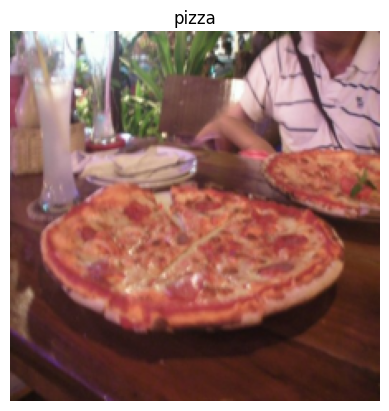

In [13]:
# View single image
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False)

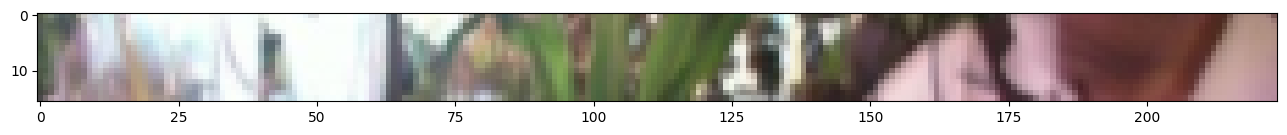

In [14]:
# Change image shape to be compativle with matplotlib
image_permuted = image.permute(1, 2, 0) # (color_channels, height, width) -> (height, width, color_channels)

# Index to plot the top row of patched pixeld
patch_size = 16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :]) # first 16 (patch_size) H, all W, all C

Number of patches per row: 14.0
Patch size: 16 pixels x 16 pixels


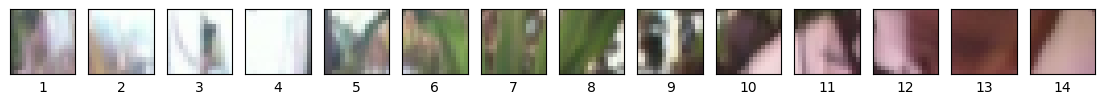

In [15]:
# Setup hyperparameters and make sure img_size and patch_size are compatible
img_size = 224
patch_size = 16
num_patches = img_size/patch_size

# If the assert failes the message is goign to show
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fig, axs = plt.subplots(nrows=1,
                        ncols=img_size // patch_size, #one col for each patch
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

# Iterate through number of patches in the top row
for i, patch in enumerate(range(0, img_size, patch_size)):
  axs[i].imshow(image_permuted[:patch_size, patch:patch+patch_size,:]) # keep height index constant, alter the width index
  axs[i].set_xlabel(i+1)
  axs[i].set_xticks([])
  axs[i].set_yticks([])

Number of patches per row: 14.0        
Number of patches per column: 14.0        
Total patches: 196.0        
Patch size: 16 pixels x 16 pixels


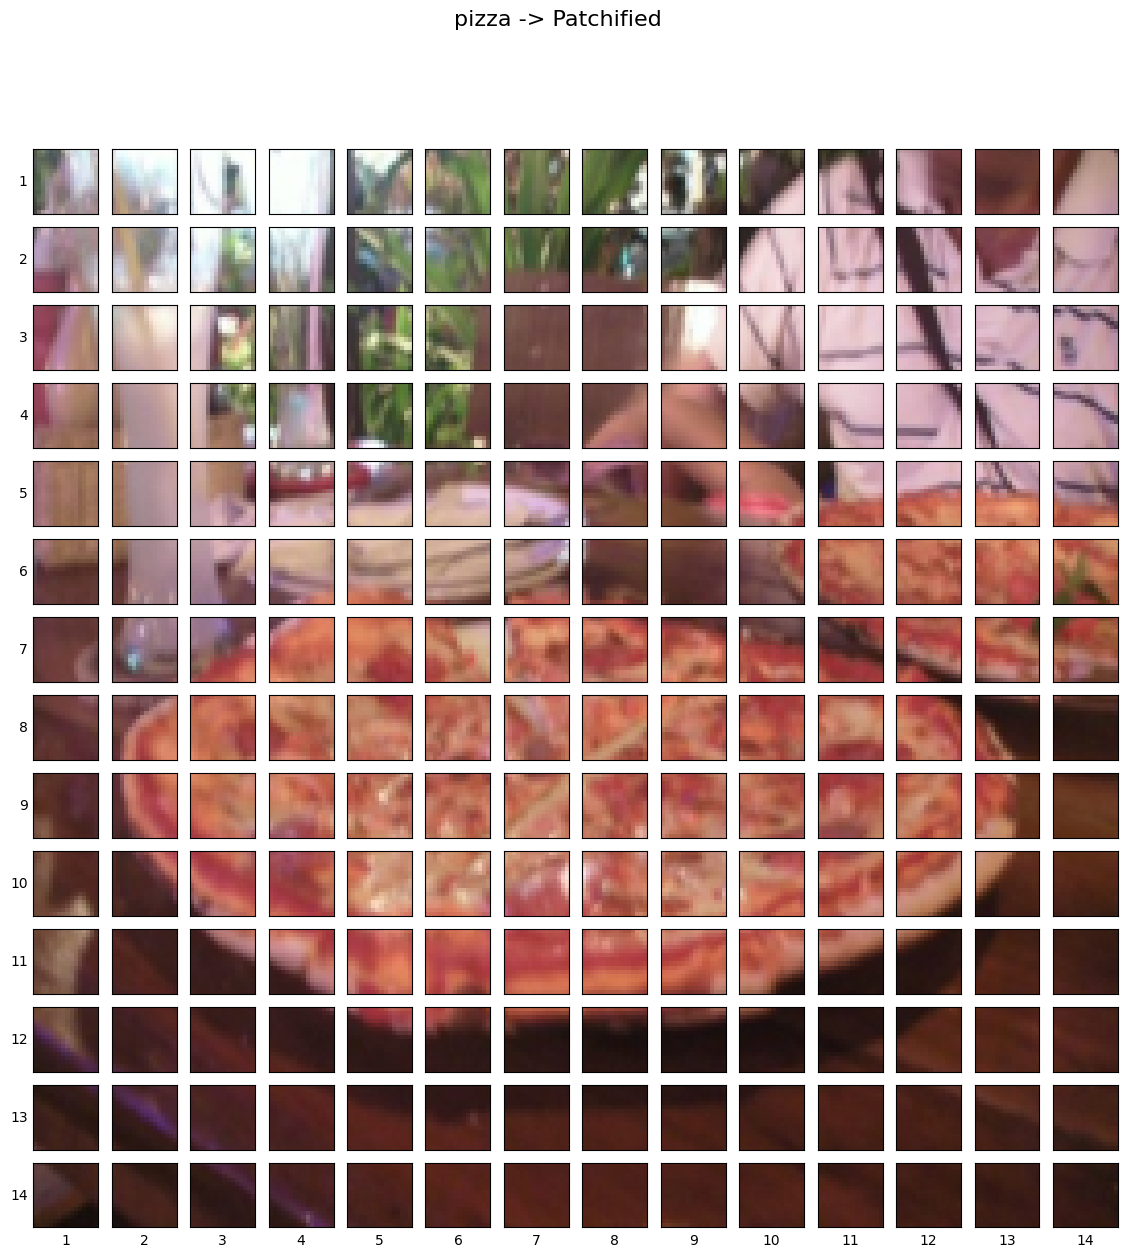

In [16]:
# Setup hyperparameters and make sure img_size and ppatch_size are compatible
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\
        \nNumber of patches per column: {num_patches}\
        \nTotal patches: {num_patches*num_patches}\
        \nPatch size: {patch_size} pixels x {patch_size} pixels")

# Creaate a series of subplots
fig, axs = plt.subplots(nrows=img_size // patch_size,
                        ncols=img_size // patch_size,
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

# Loop through height and width of iamge
for i, patch_height in enumerate(range(0, img_size, patch_size)): # iterate thourgh height
  for j, patch_width in enumerate(range(0, img_size, patch_size)): # iterate thorugh width

    # Plot the perumted image patch
    axs[i, j].imshow(image_permuted[patch_height:patch_height+patch_size, # iterate through height
                                    patch_width:patch_width+patch_size, # iterate through width
                                    :])

    # Set up label info, remove the ticks for clarity and set lables to outside
    axs[i, j].set_ylabel(i+1,
                          rotation="horizontal",
                          horizontalalignment="right",
                          verticalalignment="center")
    axs[i, j].set_xlabel(j+1)
    axs[i, j].set_xticks([])
    axs[i, j].set_yticks([])
    axs[i, j].label_outer()

# Set a super title
fig.suptitle(f"{class_names[label]} -> Patchified", fontsize=16)
plt.show()

### 4.3 Creating image paches with `torch.nn.Conv2d()`

We can replicate the creation of patches by setting the `kernel_size` and `stride` equal to `patch_size`.

This means each convolutional kernel will be of size `(patch_size x patch_size)` or if `patch_size=16`, `(16 x 16)` (the equivalent of one whole patch).

And each step or `stride` of the convolutional kernel will be `patch_size` pixels long or `16` pixels long (equivalent of stepping to the next patch).

In [17]:
from torch import nn

# Set the patch size
patch_size = 16

# Create the Conv2d layer with hyperparameters from the Vit papaer
conv2d = nn.Conv2d(in_channels=3, # number of color channe
                   out_channels=768, # from Table 1: Hidden size D, this is the embedding size
                   kernel_size=patch_size, # could also use (patch_size, patch_size)
                   stride=patch_size,
                   padding=0)


(-0.5, 223.5, 223.5, -0.5)

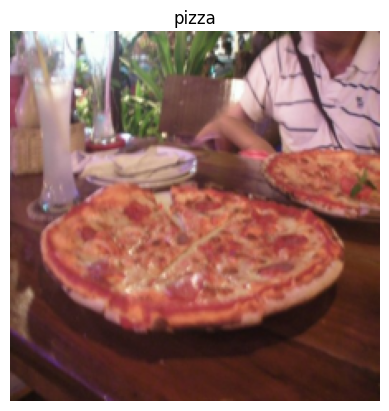

In [18]:
# View single image
plt.imshow(image.permute(1, 2, 0)) # adjust for matplotlib
plt.title(class_names[label])
plt.axis(False)

In [19]:
# Pass the iamge thorugh the convolutional layer
image_out_of_conv = conv2d(image.unsqueeze(0)) # add a single batch dim (height, width, color_channels) -> (batch, height, width, color_channels)
print(image_out_of_conv.shape)

torch.Size([1, 768, 14, 14])


torch.Size([1, 768, 14, 14]) -> [batch_size, embedding_dim, feature_map_height, feature_map_width]


Showing random convolutional feature maps from indexes: [364, 379, 566, 699, 554]


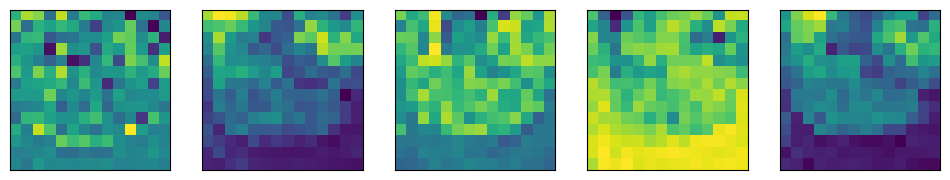

In [20]:
# Plot random 5 convolutional feature maps
import random
k = 5
random_indexes = random.sample(range(0, 768), k=k) # pick 5 numbers between 0 and the embedding size
print(f"Showing random convolutional feature maps from indexes: {random_indexes}")

# Create plot
fig, axs = plt.subplots(nrows=1, ncols=k, figsize=(12,12))

# Plot random iamge features maps
for i, idx in enumerate(random_indexes):
  image_conv_feature_map = image_out_of_conv[:, idx, :, :] # index on the output tensor of the convolutional layer
  axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy())
  axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[]);

The important thing to note is that these features may change over time as the neural network learns.

And because of these, these feature maps can be considered a learnable embedding of our image.

In [21]:
# Get a single feature map in tensor form
single_feature_map = image_out_of_conv[:, 0, :, :]
single_feature_map, single_feature_map.requires_grad, single_feature_map.shape

(tensor([[[0.2176, 0.5753, 0.7345, 0.5835, 0.3139, 0.3929, 0.2749, 0.2450,
           0.0681, 0.3701, 0.1828, 0.3353, 0.1677, 0.1163],
          [0.4131, 0.5216, 0.6694, 0.4790, 0.2545, 0.3661, 0.2496, 0.2149,
           0.2414, 0.3724, 0.4967, 0.2441, 0.3033, 0.3565],
          [0.1813, 0.4296, 0.4594, 0.3086, 0.2338, 0.2097, 0.2086, 0.2227,
           0.2900, 0.4062, 0.5174, 0.5692, 0.4115, 0.3770],
          [0.2580, 0.3325, 0.5371, 0.3274, 0.1842, 0.2093, 0.1550, 0.2145,
           0.3007, 0.3334, 0.2348, 0.4991, 0.3458, 0.4379],
          [0.2937, 0.3262, 0.4060, 0.2808, 0.4033, 0.4153, 0.4210, 0.2912,
           0.2341, 0.2526, 0.1951, 0.3490, 0.4219, 0.3959],
          [0.1880, 0.1805, 0.3349, 0.3043, 0.4733, 0.3347, 0.3111, 0.2190,
           0.1314, 0.2225, 0.2098, 0.2830, 0.2026, 0.3003],
          [0.1981, 0.2428, 0.3552, 0.3355, 0.2615, 0.2159, 0.2069, 0.2911,
           0.3026, 0.2312, 0.2475, 0.2724, 0.1501, 0.1951],
          [0.1248, 0.1426, 0.2523, 0.3231, 0.3551, 0.25

### 4.4 Flattening the patch embedding with `torch.nn.Flatten()`

We've turned our images into patch embeddings. HOw do we get them into the desired output shape of the patc hembeding layer of the Vit model?

* Desired output (1D sequence of flattened 2D patches): (196, 768) -> (number of patches, embedding dimension)

In [22]:
# Current tensor shape
print(f"Current tensor shape: {image_out_of_conv.shape} -> [batch, embedding_dim, feature_map_height, feature_map_width]")

Current tensor shape: torch.Size([1, 768, 14, 14]) -> [batch, embedding_dim, feature_map_height, feature_map_width]


We have the 768 part but still ned the number of patches.

*the input sequence is obtained by simply flattening the spatial dimensions of the feature map and projecting to the Transformer dimension.*

We don't want to flatten the whole tensor, we only want to flatten the "spatial dimensions of the feature map".

Which in our case is the feature_map_height and feature_map_width dimensions of image_out_of_conv.

In [23]:
# Create flatten layer
flatten = nn.Flatten(start_dim=2, # flatten feature map height(dim 2)
                     end_dim=3) # flatten feature_map_width(dim 3)

Original image shape: torch.Size([3, 224, 224])
Image feature map shape: torch.Size([1, 768, 14, 14])
Flattened image feature map shape: torch.Size([1, 768, 196])


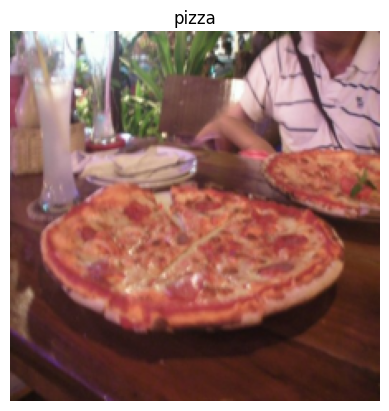

In [24]:
# 1. View single image
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False)
print(f"Original image shape: {image.shape}")

# 2. Turn image into feature maps
image_out_of_conv = conv2d(image.unsqueeze(0)) # add batch dim to avoid shape errors
print(f"Image feature map shape: {image_out_of_conv.shape}")

# 3. Flatten the feature maps
image_out_of_conv_flattened = flatten(image_out_of_conv)
print(f"Flattened image feature map shape: {image_out_of_conv_flattened.shape}")

Desired output (flattened 2D patches): (196, 768) -> N×(P2⋅C)

Current shape: (1, 768, 196)

In [25]:
# Get flattened image patch embeddings in right shape
image_out_of_conv_flattened_reshaped = image_out_of_conv_flattened.permute(0, 2, 1) # [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]
print(f"Patch embedding sequence shape: {image_out_of_conv_flattened_reshaped.shape} -> [batch_size, num_patches, embedding_size]")

Patch embedding sequence shape: torch.Size([1, 196, 768]) -> [batch_size, num_patches, embedding_size]


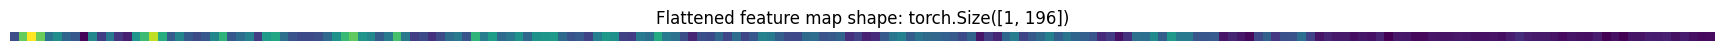

In [26]:
# Get a single flattened feature map
single_flattened_feature_map = image_out_of_conv_flattened_reshaped[:, :, 0] # index: (batch_size, number_of_patches, embedding_dimension)

# Plot the flattened feature map visually
plt.figure(figsize=(22,22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Flattened feature map shape: {single_flattened_feature_map.shape}")
plt.axis(False);

In [27]:
# See the flattened feature map as a tensor
single_flattened_feature_map, single_flattened_feature_map.requires_grad, single_flattened_feature_map.shape

(tensor([[0.2176, 0.5753, 0.7345, 0.5835, 0.3139, 0.3929, 0.2749, 0.2450, 0.0681,
          0.3701, 0.1828, 0.3353, 0.1677, 0.1163, 0.4131, 0.5216, 0.6694, 0.4790,
          0.2545, 0.3661, 0.2496, 0.2149, 0.2414, 0.3724, 0.4967, 0.2441, 0.3033,
          0.3565, 0.1813, 0.4296, 0.4594, 0.3086, 0.2338, 0.2097, 0.2086, 0.2227,
          0.2900, 0.4062, 0.5174, 0.5692, 0.4115, 0.3770, 0.2580, 0.3325, 0.5371,
          0.3274, 0.1842, 0.2093, 0.1550, 0.2145, 0.3007, 0.3334, 0.2348, 0.4991,
          0.3458, 0.4379, 0.2937, 0.3262, 0.4060, 0.2808, 0.4033, 0.4153, 0.4210,
          0.2912, 0.2341, 0.2526, 0.1951, 0.3490, 0.4219, 0.3959, 0.1880, 0.1805,
          0.3349, 0.3043, 0.4733, 0.3347, 0.3111, 0.2190, 0.1314, 0.2225, 0.2098,
          0.2830, 0.2026, 0.3003, 0.1981, 0.2428, 0.3552, 0.3355, 0.2615, 0.2159,
          0.2069, 0.2911, 0.3026, 0.2312, 0.2475, 0.2724, 0.1501, 0.1951, 0.1248,
          0.1426, 0.2523, 0.3231, 0.3551, 0.2562, 0.3187, 0.2902, 0.2798, 0.2679,
          0.2529

### 4.5 Turning the Vit patch embedding layer into a PyTorch module

In [28]:
# 1. Create a class which subclasses nn.Module
class PatchEmbedding(nn.Module):
  ''' Turns a 2d input image into a 1D sequence learnable embedding vector.

  Args:
      in_channels (int): Number of color channels for the input images. Defaults to 3.
      patch_size (int): Size of patches to convert input image into. Defaults to 16.
      embedding_dim (int): Size of embedding to turn image into. Defaults to 768.
  '''
  # 2. Initialize the class with appropriate variables
  def __init__(self,
               in_channels: int = 3,
               patch_size: int = 16,
               embedding_dim: int=768):
    super().__init__()

    # 3. Create a layer to turn an image into patches
    self.patcher = nn.Conv2d(in_channels=in_channels,
                             out_channels=embedding_dim,
                             kernel_size=patch_size,
                             stride=patch_size,
                             padding=0)

    # 4. Create a layer to flatten the patch feature maps into a single dim
    self.flatten = nn.Flatten(start_dim = 2, # only flatten the feature map dim into a single cevtor
                              end_dim = 3)

  # 5. Define the forward method
  def forward(self, x):
      # Create assertion to check that inputs are the correct shape
      image_resolution = x.shape[-1]
      assert image_resolution % patch_size ==0, f"Input iamge size must be divisiebl by patch size, image shape: {image_resolution}, patch size: {patch_size} "

      # Perform the forward pass
      x_patched = self.patcher(x)
      x_flattend = self.flatten(x_patched)
      # 6. Make sure the output shape has the right order
      return x_flattend.permute(0, 2, 1)# adjust so the embedding is on the final dimension [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]

In [29]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Create an instance of patch embedding layer
patchify = PatchEmbedding(in_channels=3,
                          patch_size=16,
                          embedding_dim=768)

# Pass a single image through
print(f"Input image shape: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0)) # add an extra batch dimension on the 0th index, otherwise will error
print(f"Output patch embedding shape: {patch_embedded_image.shape}")

Input image shape: torch.Size([1, 3, 224, 224])
Output patch embedding shape: torch.Size([1, 196, 768])


<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-replicating-the-patch-embedding-layer.png"/>

In [30]:
# Create random input sizes
random_input_image = (1, 3, 224, 224)

# Get a summary of the input and outputs of PatchEmbedding (uncomment for full output)
summary(PatchEmbedding(),
        input_size=random_input_image, # try swapping this for "random_input_image_error"
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
PatchEmbedding (PatchEmbedding)          [1, 3, 224, 224]     [1, 196, 768]        --                   True
├─Conv2d (patcher)                       [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
├─Flatten (flatten)                      [1, 768, 14, 14]     [1, 768, 196]        --                   --
Total params: 590,592
Trainable params: 590,592
Non-trainable params: 0
Total mult-adds (M): 115.76
Input size (MB): 0.60
Forward/backward pass size (MB): 1.20
Params size (MB): 2.36
Estimated Total Size (MB): 4.17

### 4.6 Creating the class token embedding

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-equation-1-the-class-token.png"/>

So we need to "preprend a learnable embedding to the sequence of embedded patches".



In [31]:
# View the patch embedding and patch embedding shape
print(patch_embedded_image)
print(f"Patch embedding shape: {patch_embedded_image.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[-0.8342,  0.2416, -0.1621,  ...,  0.5358, -0.2584,  0.0232],
         [-0.9266,  0.2262, -0.0807,  ...,  0.6340, -0.4805,  0.2140],
         [-0.9474,  0.1946, -0.2270,  ...,  0.5176, -0.4674,  0.5893],
         ...,
         [-0.1864, -0.0100, -0.0433,  ...,  0.1003, -0.0949,  0.0682],
         [-0.1741, -0.0040, -0.0377,  ...,  0.1005, -0.0856,  0.0674],
         [-0.1370, -0.0047, -0.0442,  ...,  0.0845, -0.0802,  0.0831]]],
       grad_fn=<PermuteBackward0>)
Patch embedding shape: torch.Size([1, 196, 768]) -> [batch_size, number_of_patches, embedding_dimension]


we need to create a learnable embedding in the shape of the embedding_dimension (D) and then add it to the number_of_patches dimension.



In [32]:
# Get the batch size and embedding dimension
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]

# Create the class token embedding as a learnable parameter that share the same szie as the embedding dimension (D)
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension), # [batch_size, number_of_tokens, embedding_dimension]
                           requires_grad=True) # make sure the embedding is learnable

# Show the feist 10 examples of the class_token
print(class_token[:, :, :10])

# Print the class_token shape
print(f"Class token shape: {class_token.shape} -> [batch_size, number_of_tokens, embedding_dimension]")

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
Class token shape: torch.Size([1, 1, 768]) -> [batch_size, number_of_tokens, embedding_dimension]


Now we've got the class token embedding, let's prepend it to our sequence of image patches, patch_embedded_image.

We can do so using torch.cat() and set dim=1 (so class_token's number_of_tokens dimension is preprended to patch_embedded_image's number_of_patches dimension).

In [33]:
# Add the class token embedding to the front of the patch embedding
patch_embedded_image_with_class_embedding = torch.cat((class_token, patch_embedded_image),
                                                      dim=1) # concat on first dimension

# Print the sequence of patch embeddings with the prepended class token embedding
print(patch_embedded_image_with_class_embedding)
print(f"Sequence of patch embeddings with class token prepended shape: {patch_embedded_image_with_class_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-0.8342,  0.2416, -0.1621,  ...,  0.5358, -0.2584,  0.0232],
         [-0.9266,  0.2262, -0.0807,  ...,  0.6340, -0.4805,  0.2140],
         ...,
         [-0.1864, -0.0100, -0.0433,  ...,  0.1003, -0.0949,  0.0682],
         [-0.1741, -0.0040, -0.0377,  ...,  0.1005, -0.0856,  0.0674],
         [-0.1370, -0.0047, -0.0442,  ...,  0.0845, -0.0802,  0.0831]]],
       grad_fn=<CatBackward0>)
Sequence of patch embeddings with class token prepended shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-equation-1-prepending-the-learnable-class-token.png"/>

### 4.7 Creating the postion embedding

Well, we've got the class token embedding and the patch embedding, now how might we create the position embedding?

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-equation-1-the-position-embeddings.png"/>

By "retain positional information" the authors mean they want the architecture to know what "order" the patches come in. As in, patch two comes after patch one and patch three comes after patch two and on and on.

This positional information can be important when considering what's in an image (without positional information an a flattened sequence could be seen as having no order and thus no patch relates to any other patch).

In [34]:
# View the sequence of patch embeddings with the prepended class embedding
patch_embedded_image_with_class_embedding, patch_embedded_image_with_class_embedding.shape

(tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [-0.8342,  0.2416, -0.1621,  ...,  0.5358, -0.2584,  0.0232],
          [-0.9266,  0.2262, -0.0807,  ...,  0.6340, -0.4805,  0.2140],
          ...,
          [-0.1864, -0.0100, -0.0433,  ...,  0.1003, -0.0949,  0.0682],
          [-0.1741, -0.0040, -0.0377,  ...,  0.1005, -0.0856,  0.0674],
          [-0.1370, -0.0047, -0.0442,  ...,  0.0845, -0.0802,  0.0831]]],
        grad_fn=<CatBackward0>),
 torch.Size([1, 197, 768]))

EQ 1. states that the position embeddings (E_pos) should have the shape (N+1) * D

In [35]:
# Calcualte N (number of patches)
number_of_patches = int((height * width) / patch_size**2)

# Get embedding dim
embedding_dimension = patch_embedded_image_with_class_embedding.shape[2]

# Create the lernable 1D postion embedding
position_embedding = nn.Parameter(
    torch.ones(
        1,
        number_of_patches+1,
        embedding_dimension),
    requires_grad=True
)

# Show the frist 10 sequences and 10 position emebdding values and check the sahpe of the position embedding dim
print(position_embedding[:, :10, :10])
print(f"Position embeddding shape: {position_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
Position embeddding shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


In [36]:
# Add the position embedding to the patch and class token embedding
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding
print(patch_and_position_embedding)
print(f"Patch embeddings, class token prepended and positional embeddings added shape: {patch_and_position_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.1658, 1.2416, 0.8379,  ..., 1.5358, 0.7416, 1.0232],
         [0.0734, 1.2262, 0.9193,  ..., 1.6340, 0.5195, 1.2140],
         ...,
         [0.8136, 0.9900, 0.9567,  ..., 1.1003, 0.9051, 1.0682],
         [0.8259, 0.9960, 0.9623,  ..., 1.1005, 0.9144, 1.0674],
         [0.8630, 0.9953, 0.9558,  ..., 1.0845, 0.9198, 1.0831]]],
       grad_fn=<AddBackward0>)
Patch embeddings, class token prepended and positional embeddings added shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


Notice how the values of each of the elements in the embedding tensor increases by 1 (this is because of the position embeddings being created with torch.ones()).

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-equation-1-patch-embeddings-with-learnable-class-token-and-position-embeddings.png"/>


### NOTE FORM SELF


In vision transformers (ViTs) and similar transformer-based models, both class token embeddings and positional embeddings play important roles in capturing spatial relationships and global context in the input data.

1. Class Token Embedding:

* Role: The class token embedding represents the global or holistic information of the entire input image. It serves as a summary of the entire image content.
* Usage: Typically, the class token embedding is concatenated with the patch embeddings (representing local information) and fed into the transformer model as part of the input sequence. This allows the model to attend to both local and global features during processing.
2. Positional Embedding:

* Role: The positional embedding provides information about the spatial arrangement of tokens in the input sequence. Transformers, by design, do not inherently understand the order or position of tokens in a sequence. Positional embeddings are added to the token embeddings to inject spatial information.
* Usage: Each token (including the class token) is associated with a positional embedding vector. This combination of token and positional embeddings helps the transformer model take into account the spatial relationships between different parts of the input.

### 4.8 Putting it all together: from image to embedding

We can do so by:

1. Setting the patch size (we'll use 16 as it's widely used throughout the paper and for ViT-Base).
2. Getting a single image, printing its shape and storing its height and width.
3. Adding a batch dimension to the single image so it's compatible with our PatchEmbedding layer.
4. Creating a PatchEmbedding layer (the one we made in section 4.5) with a patch_size=16 and embedding_dim=768 (from Table 1 for ViT-Base).
5. Passing the single image through the PatchEmbedding layer in 4 to create a sequence of patch embeddings.
6. Creating a class token embedding like in section 4.6.
7. Prepending the class token embedding to the patch embeddings created in step 5.
8. Creating a position embedding like in section 4.7.
9. Adding the position embedding to the class token and patch embeddings created in step 7.

In [37]:
set_seeds()

# 1. Set patch size
patch_size = 16

# 2. Print shape of original image tensor and get the image dims
print(f"Image tensor shape: {image.shape}")
height, wdith = image.shape[1], image.shape[2]

# 3. Get the image tensor and add abtch dim
x = image.unsqueeze(0)
print(f"Input image with batch dim shape: {x.shape}")

# 4. Create patch embedding layer
patch_embedding_layer = PatchEmbedding(in_channels=3,
                                       patch_size=patch_size,
                                       embedding_dim=768)

# 5. Pass image through patch embedding layer
patch_embedding = patch_embedding_layer(x)
print(f"Patching embedding shape: {patch_embedding.shape}")

# 6. Create class token embedding
batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True)
print(f"Class token embedding shape: {class_token.shape}(1 and has 768 values inside) ")

# 7. Prepend class token embedding to patch embeding
patch_embedding_class_token = torch.cat((class_token,patch_embedding), dim=1)
print(f"Patch embedding with class token shape: {patch_embedding_class_token.shape}")

# 8. Create position embedding
number_of_patches = int((height*width) / patch_size**2)
position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension),
                                  requires_grad=True)

# 9. Add positon embeddign to patch embedding with class token
patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape}")

Image tensor shape: torch.Size([3, 224, 224])
Input image with batch dim shape: torch.Size([1, 3, 224, 224])
Patching embedding shape: torch.Size([1, 196, 768])
Class token embedding shape: torch.Size([1, 1, 768])(1 and has 768 values inside) 
Patch embedding with class token shape: torch.Size([1, 197, 768])
Patch and position embedding shape: torch.Size([1, 197, 768])


<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-equation-1-putting-it-all-together.png"/>

<img src="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/images/08-vit-paper-architecture-animation-full-architecture.gif"/>

## 5. Equation 2: Multi_head Attention(MSA)

A Multi-Head Attention (MSA) layer wrapped in a LayerNorm(LN) layer with a residual connection (the input to the layer gets added to the output of the layer).

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-equation-2-msa-block-mapped-to-equation.png"/>

**Left:** Figure 1 from the ViT paper with Multi-Head Attention and Norm layers as well as the residual connection (+) highlighted within the Transformer Encoder block. Right: Mapping the Multi-Head Self Attention (MSA) layer, Norm layer and residual connection to their respective parts of equation 2 in the ViT paper.

* Multi-Head Self Attention (MSA) - torch.nn.MultiheadAttention().
* Norm (LN or LayerNorm) - torch.nn.LayerNorm().
* Residual connection - add the input to output (we'll see this later on when we create the full Transformer Encoder block in section 7.1).

### 5.1 The LayerNorm (LN) layer

Layer Normalization (torch.nn.LayerNorm() or Norm or LayerNorm or LN) normalizes an input over the last dimension.

PyTorch's torch.nn.LayerNorm()'s main parameter is normalized_shape which we can set to be equal to the dimension size we'd like to noramlize over (in our case it'll be D or 768 for ViT-Base).

Layer Normalization helps improve training time and model generalization (ability to adapt to unseen data).

I like to think of any kind of normalization as "getting the data into a similar format" or "getting data samples into a similar distribution".

Imagine trying to walk up (or down) a set of stairs all with differing heights and lengths.

It'd take some adjustment on each step right?

And what you learn for each step wouldn't necessary help with the next one since they all differ, increasing the time it takes you to navigate the stairs.

Normalization (including Layer Normalization) is the equivalent of making all the stairs the same height and length except the stairs are your data samples.

So just like you can walk up (or down) stairs with similar heights and lengths much easier than those with unequal heights and widths, neural networks can optimize over data samples with similar distributions (similar mean and standard-deviations) easier than those with varying distributions.

### 5.2 The Multi-Head Self Attnetion(MSA) layer

The self-attention and multi-head attention (self-attention applied multiple times) cames from the origian lTransfomrer architecture introduced in the Attention is all you need research paper. (https://jalammar.github.io/illustrated-transformer/)

The original self-attention mechanism takes a sequence of words and then calculates which word should pay more "attention" to another word.

Since our input is a sequence of image patches rather than words, self-attention and in turn multi-head attention will calculate which patch of an image is most related to another patch, eventually forming a learned representation of an image.

But what's most important is that the layer does this on it's own given the data (we don't tell it what patterns to learn).



<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-equation-2-appendix-A.png" width = 10000 />

The image above highlights the triple embedding input to the MSA layer.

This is known as query, key, value input or qkv for short which is fundamental to the self-attention mechanism.

We can implement the MSA layer in PyTorch with torch.nn.MultiheadAttention() with the parameters:

* `embed_dim` - the embedding dimension from Table 1 (Hidden size D).
* `num_heads` - how many attention heads to use (this is where the term "multihead" comes from), this value is also in Table 1 (Heads).
* `dropout` - whether or not to apply dropout to the attention layer (according to Appendix B.1, dropout isn't used after the qkv-projections).
* `batch_first` - does our batch dimension come first? (yes it does)


### 5.3 Replicating Equation 2 with PyTorch layers

1. Create a class called MultiheadSelfAttentionBlock that inherits from torch.nn.Module.
2. Initialize the class with hyperparameters from Table 1 of the ViT paper for the ViT-Base model.
3. Create a layer normalization (LN) layer with torch.nn.LayerNorm() with the normalized_shape parameter the same as our embedding dimension (D from Table 1).
4. Create a multi-head attention (MSA) layer with the appropriate embed_dim, num_heads, dropout and batch_first parameters.
5. Create a forward() method for our class passing the in the inputs through the LN layer and MSA layer.

In [38]:
# 1. Create a class that inherits from nn.Module
class MultiheadSelfAttentionBlock(nn.Module):
  ''' Creates a mulit-head self-attention bloack(MSA block) '''

  # 2. Initialize the class with hyperparameters from Table 1
  def __init__(self,
               embedding_dim:int=768, # Hidden size D from Table 1 for Vit-Base
               num_heads:int=12, # Heads from Table 1 for Vit-Base
               attn_dropout:float=0): # does not look like the paper uses any drouput
      super().__init__()

      # 3. Create the Norm layer (LN)
      self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

      # 4. Create the Multi-Head Attention (MSA) layer
      self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                  num_heads=num_heads,
                                                  dropout=attn_dropout,
                                                  batch_first=True) # does our batch dim come first?

  # 5. Create a forward() method to pass the data thorug the layers
  def forward(self, x):
    x = self.layer_norm(x)
    # attn_output, need_weight(but since need_weight=False only attn_output)
    attn_output, _ = self.multihead_attn(query=x, # query embeddings
                                         key=x, # key embeddings
                                         value=x, # value embeddings
                                         need_weights=False) # do we need the wieghts or just the layer outputs?
    return attn_output

In [39]:
# Create an instance of MSABlock
multihead_self_attention_block = MultiheadSelfAttentionBlock(embedding_dim=768, # from Table 1
                                                             num_heads=12) # from Table 1

# Pass patch and position image embedding through MSABlock
patched_image_through_msa_block = multihead_self_attention_block(patch_and_position_embedding)
print(f"Input shape of MSA block: {patch_and_position_embedding.shape}")
print(f"Output shape MSA block: {patched_image_through_msa_block.shape}")

Input shape of MSA block: torch.Size([1, 197, 768])
Output shape MSA block: torch.Size([1, 197, 768])


<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-equation-2-in-code.png" width = 10000 />

## 6. Equation 3: Multilayer Perceptron (MLP)

Here MLP stands for "multilayer perceptron" and LN stands for "layer normalization". And the addition on the end is the skip/residual connection.

<img src="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/images/08-vit-paper-equation-3-annotated.png" width = 10000 />



### 6.1 The MLP layer

MLP generally follows this pattern:

`linear layer -> non-linear layer -> linear layer -> non-linear layer`

In the case of ViT paper:

*The MLP contains two layers with GELU non-linearity.*

And in the appendix it says:

*Table 3 summarizes our training setups for our different models. ...Dropout, when used, is applied after every dense layer except for the the qkv-projections and directly after adding positional- to patch embeddings.*

Knowing this, the structure of our MLP block will be:

*layer norm -> linear layer -> non-linear layer -> dropout -> linear layer -> dropout*

<img src="https://images.squarespace-cdn.com/content/v1/5f831c8e85a8ea3b5baabcbd/7f4cdc6f-798f-45db-831f-b0aaf7cb6f72/1*LIIoilXGJLdLpu_oTf_PSw.png" width = 10000 />


<img src="https://www.researchgate.net/publication/370116538/figure/fig3/AS:11431281150943302@1681926313798/Comparison-of-the-ReLu-and-GeLu-activation-functions-ReLu-is-simpler-to-compute-but.ppm" width = 10000 />

### 6.2 Replicating Equation 3 with PyTorch layers

1. Create a class called `MLPBlock` that inherits from `torch.nn.Module`.
2. Initialize the class with hyperparametrs from Table 1 and Table 3 of the Vit Paper of the ViT-Base model,
3. Create a layer normalization (LN) layer with `torch.nn.LayerNorm()` with the `normalized_shape` parameter the same as our embedding dimension (D from Table 1).
4. Create a sequential series of MLP layers(s) using `torch.nn.Linear()`, `torch.nn.Dropout()` and `torch.nn.GELU()` with appropriate hyperparameter values from Table 1 and Table 3.
5. Create a `forward()` method for our class passing the in the inputs through the LN layer and MLP layer(s).


In [40]:
# 1. Create a class that inhertis from nn.Module
class MLPBlock(nn.Module):
  ''' Creates a layer normalized multilayer perceptron block("MLP Block") '''
  # 2. Initialize the class with hyperparameters from Table 1 and Table 3
  def __init__(self,
               embedding_dim:int=768, # Hidden Size D from Table 1 for ViT-Base
               mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
               dropout:float=0.1): # Dropout from Table 3 for ViT-Base
      super().__init__()

      # 3. Create the NOrm layer(LN)
      self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

      # 4. Create the MLP layers
      self.mlp = nn.Sequential(
          nn.Linear(in_features=embedding_dim,
                    out_features=mlp_size),
          nn.GELU(),
          nn.Dropout(p=dropout),
          nn.Linear(in_features=mlp_size, # needs to take same in_features as out_features of layer above
                    out_features=embedding_dim), # take back to embedding_dim
          nn.Dropout(p=dropout) # "Dropout, when used, is applied after every dense layer.."
      )

  def forward(self, x):
    x = self.layer_norm(x)
    x = self.mlp(x)
    return x

Note: Unlike Figure 1, our MLPBlock() doesn't include a skip or residual connection ("+z′ℓ") in equation 3), we'll include this when we create the entire Transformer encoder later on.

In [41]:
# Create an instance of MLPBlock
mlp_block = MLPBlock(embedding_dim=768, # Table 1
                     mlp_size=3072, # Table 1
                     dropout=0.1) # Table 3

# Pass output of MSABlock through MLPBlock
patched_image_through_mlp_block = mlp_block(patched_image_through_msa_block)
print(f"Input shape of MLP block: {patched_image_through_msa_block.shape}")
print(f"Output shape MLP block: {patched_image_through_mlp_block.shape}")

Input shape of MLP block: torch.Size([1, 197, 768])
Output shape MLP block: torch.Size([1, 197, 768])


<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-equation-3-mapped-to-code.png" width = 10000 />

## 7. Create the Transformer Encoder

In deep learning, an "encoder" or "auto encoder" generally refers to a stack of layers that "encodes" an input (turns it into some form of numerical representation).

We've created MSA and MLP blocks but what about the residual connections?

Residual connections (also called skip connections), were first introduced in the paper Deep Residual Learning for Image Recognition and are achieved by adding a layer(s) input to its subsequent output.

One of the main ideas behind residual connections is that they prevent weight values and gradient updates from getting too small and thus allow deeper networks and in turn allow deeper representations to be learned.




### 7.1 Creating a Transformer Encoder by combining our custom made layers

1. Create a class called `TransformerEncoderBlock` that inherits from `torch.nn.Module.`
2. Initialize the class with hyperparameters from Table 1 and Table 3 of the ViT paper for the ViT-Base model.
3. Instantiate a MSA block for equation 2 using our `MultiheadSelfAttentionBlock` from section 5.2 with the appropriate parameters.
4. Instantiate a MLP block for equation 3 using our MLPBlock from section 6.2 with the appropriate parameters.
5. Create a `forward()` method for our TransformerEncoderBlock class.
6. Create a residual connection for the MSA block (for equation 2).
7. Create a residual connection for the MLP block (for equation 3).

In [42]:
# 1. Create a class that inherits from nn.Module
class TransformerEncoderBlock(nn.Module):
  ''' Create a Transformer Encoder black. '''
  def __init__(self,
               embedding_dim:int=768, # Table 1
               num_heads:int=12, # Table 1
               mlp_size:int=3072, # Table 1
               mlp_dropout:float=0.1, # Table 3
               attn_dropout:float=0):
    super().__init__()

    # 3. Create MSA block(equation 2)
    self.msa_block = MultiheadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                 num_heads=num_heads,
                                                 attn_dropout=attn_dropout)

    # 4. Create MLP block (equation 3)
    self.mlp_block = MLPBlock(embedding_dim=embedding_dim,
                              mlp_size=mlp_size,
                              dropout=mlp_dropout)

  # 5. Create a forward() method
  def forward(self, x):

    # 6. Create residual connection for MSA block
    x = self.msa_block(x) + x

    # 7. Create residual connection for MLP block
    x = self.mlp_block(x) + x

    return x

<img src="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/images/08-vit-paper-transformer-encoder-highlighted.png" width = 10000 />

<img src="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/images/08-vit-paper-transformer-encoder-mapped-to-code.png" width = 10000 />

In [43]:
# Create an instance of TransformerEncoderBlock
transformer_encoder_block = TransformerEncoderBlock()

# Print an input and output summary of our Transformer Encoder (uncomment for full output)
summary(model=transformer_encoder_block,
        input_size=(1, 197, 768), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiheadSelfAttentionBlock (msa_block)          [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attn)         --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                             [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

### 7.2 Creating a Transformer Encoder with PyTorch's Transformer layers

Becasue of the rise of popularity of transformers torch added their own.

In [44]:
# Create the same as above with torch.nn.TransformerEncoderLayer()
torch_transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=768, # Table 1
                                                             nhead=12, # Table 1
                                                             dim_feedforward=3072, # Table 1
                                                             dropout=0.1, # Table 3
                                                             activation="gelu", # GELU
                                                             batch_first=True, # Do our batches come first?
                                                             norm_first=True) # normalize first or after MSA/MLP layers ?

torch_transformer_encoder_layer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [45]:
# Get the output of PyTorch's version of the Transformer Encoder (uncomment for full output)
summary(model=torch_transformer_encoder_layer,
        input_size=(1, 197, 768), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 197, 768]        [1, 197, 768]        7,087,872            True
Total params: 7,087,872
Trainable params: 7,087,872
Non-trainable params: 0
Total mult-adds (M): 0
Input size (MB): 0.61
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.61

Since the ViT architecture uses several Transformer Layers stacked on top of each for the full architecture (Table 1 shows 12 Layers in the case of ViT-Base), you can do this with torch.nn.TransformerEncoder(encoder_layer, num_layers) where:

* encoder_layer - The target Transformer Encoder layer created with torch.nn.TransformerEncoderLayer().
* num_layers - The number of Transformer Encoder layers to stack together.

## 8. Putting it all together to create ViT

For equation 4 all we need is a `torch.nn.LayerNorm()` layer and a `torch.nn.Linear()` layer to convert the 0th index (z0L) of the Transformer Encoder logit outputs to the target number of classes we have.

Finally, to bring our own implementation of ViT to life, let's:

1. Create a class called ViT that inherits from torch.nn.Module.
2. Initialize the class with hyperparameters from Table 1 and Table 3 of the ViT paper for the ViT-Base model.
3. Make sure the image size is divisible by the patch size (the image should be split into even patches).
4. Calculate the number of patches using the formula N=HW/P**2, where H is the image height, W is the image width and P is the patch size.
5. Create a learnable class embedding token (equation 1) as done above in section 4.6.
6. Create a learnable position embedding vector (equation 1) as done above in section 4.7.
7. Setup the embedding dropout layer as discussed in Appendix B.1 of the ViT paper.
8. Create the patch embedding layer using the PatchEmbedding class as above in section 4.5.
9. Create a series of Transformer Encoder blocks by passing a list of TransformerEncoderBlocks created in section 7.1 to torch.nn.Sequential() (equations 2 & 3).
10. Create the MLP head (also called classifier head or equation 4) by passing a torch.nn.LayerNorm() (LN) layer and a torch.nn.Linear(out_features=num_classes) layer (where num_classes is the target number of classes) linear layer to torch.nn.Sequential().
11. Create a forward() method that accepts an input.
12. Get the batch size of the input (the first dimension of the shape).
13. Create the patching embedding using the layer created in step 8 (equation 1).
14. Create the class token embedding using the layer created in step 5 and expand it across the number of batches found in step 11 using torch.Tensor.expand() (equation 1).
15. Concatenate the class token embedding created in step 13 to the first dimension of the patch embedding created in step 12 using torch.cat() (equation 1).
16. Add the position embedding created in step 6 to the patch and class token embedding created in step 14 (equation 1).
17. Pass the patch and position embedding through the dropout layer created in step 7.
18. Pass the patch and position embedding from step 16 through the stack of 19. Transformer Encoder layers created in step 9 (equations 2 & 3).
19. Pass index 0 of the output of the stack of Transformer Encoder layers from step 17 through the classifier head created in step 10 (equation 4).


In [46]:
# 1. Create a ViT class that inherits from nn.Module
class ViT(nn.Module):
  ''' Create a Vision Transformer architecture with ViT-Base hyperparameters by deafult. '''
  # 2. Initialize the class with hyperparametrs from Tbale 1 and Table 3
  def __init__(self,
              img_size:int=224, # Training resolution from Table 3 in ViT paper
              in_channels:int=3, # Number of channels in input image
              patch_size:int=16, # Patch size
              num_transformer_layers:int=12, # Layers from Table 1 for ViT-Base
              embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
              mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
              num_heads:int=12, # Heads from Table 1 for ViT-Base
              attn_dropout:float=0, # Dropout for attention projection
              mlp_dropout:float=0.1, # Dropout for dense/MLP layers
              embedding_dropout:float=0.1, # Dropout for patch and position embeddings
              num_classes:int=1000): # Default for ImageNet but can customize this
    super().__init__()

    # 3. Make the image size is divisible by the patch size
    assert img_size % patch_size == 0, f"Image size must be divisible by patch size"

    # 4. Calculate number of patches (height * width/patch^2)
    self.num_patches = (img_size * img_size) // patch_size ** 2

    # 5. Create learnable class embedding (needs to go at front of sequence of patc hemebedings)
    self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                        requires_grad=True)

    # 6. Create lernable position embedding                   + 1 because we also inclue the class_embedding
    self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim),
                                           requires_grad=True)

    # 7. Create embedding droput value
    self.embedding_dropout = nn.Dropout(p=embedding_dropout)

    # 8. Create patch embedding layer
    self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                          patch_size=patch_size,
                                          embedding_dim=embedding_dim)

    # 9. Create Transfomere Encoder blacks( we can stack Transformer Encoder blocks using nn.Sequential())
    # "*" means "all"
    self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                            num_heads=num_heads,
                                                                            mlp_size=mlp_size,
                                                                            mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])

    # 10. Create classifier head
    self.classifier = nn.Sequential(
        nn.LayerNorm(normalized_shape=embedding_dim),
        nn.Linear(in_features=embedding_dim,
                  out_features=num_classes)
    )

  # 11. Create a forward() method
  def forward(self, x):

    # 12. Get batch size
    batch_size = x.shape[0]

    # 13. Create class token embedding and expand it to mach the batch size (equation 1)
    class_token = self.class_embedding.expand(batch_size, -1, -1) # "-1" means to infer the dimension

    # 14. Create patch embedding (equation 1)
    x = self.patch_embedding(x)

    # 15. Concat class embedding and patch embedding (equation 1)
    x = torch.cat((class_token, x), dim=1)

    # 16. Add position embedding to patch embedding (equation 1)
    x = self.position_embedding + x

    # 17. Run embedding dropout
    x = self.embedding_dropout(x)

    # 18. Pass patch, position and class embedding thorugh transformer encoder layers (equation 2 & 3)
    x = self.transformer_encoder(x)

    # 19. Put 0 index logit throguh classifier (equation 4)
    x = self.classifier(x[:, 0]) # run on each sample in a batch at 0 index

    return x

In [47]:
# Example of creating the class embedding and expanding over a batch dimension
batch_size = 32
class_token_embedding_single = nn.Parameter(data=torch.randn(1, 1, 768)) # create a single learnable class token
class_token_embedding_expanded = class_token_embedding_single.expand(batch_size, -1, -1) # expand the single learnable class token across the batch dimension, "-1" means to "infer the dimension"

# Print out the change in shapes
print(f"Shape of class token embedding single: {class_token_embedding_single.shape}")
print(f"Shape of class token embedding expanded: {class_token_embedding_expanded.shape}")

Shape of class token embedding single: torch.Size([1, 1, 768])
Shape of class token embedding expanded: torch.Size([32, 1, 768])



Notice how the first dimension gets expanded to the batch size and the other dimensions stay the same (because they're inferred by the "-1" dimensions in .expand(batch_size, -1, -1)).

In [48]:
set_seeds()

# Create a random tensor with same shape as a single image
random_image_tensor = torch.randn(1, 3, 224, 224) # (batch_size, color_channels, height, width)

# Create an instance of ViT with the number of classes we're working with (pizza, steak, sushi)
vit = ViT(num_classes=len(class_names))

# Pass the random image tensor to our ViT instance
vit(random_image_tensor)

tensor([[-0.2377,  0.7360,  1.2137]], grad_fn=<AddmmBackward0>)

### 8.1 Getting a visual summary of our ViT model

In [49]:
from torchinfo import summary

# Print a summary of our custom ViT model using torchinfo (uncomment for actual output)
summary(model=vit,
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                    [32, 3, 224, 224]    [32, 3]              152,064              True
├─PatchEmbedding (patch_embedding)                           [32, 3, 224, 224]    [32, 196, 768]       --                   True
│    └─Conv2d (patcher)                                      [32, 3, 224, 224]    [32, 768, 14, 14]    590,592              True
│    └─Flatten (flatten)                                     [32, 768, 14, 14]    [32, 768, 196]       --                   --
├─Dropout (embedding_dropout)                                [32, 197, 768]       [32, 197, 768]       --                   --
├─Sequential (transformer_encoder)                           [32, 197, 768]       [32, 197, 768]       --                   True
│    └─TransformerEncoderBlock (0)                           [32, 197, 768]       [32, 197, 768]

## 9. Setting up training code for our ViT model

### 9.1 Creating an optimzier

The paper describes Adam optimizer wiht beta parameters (0.9, 0.999) and a weight decay of 0.3.

### 9.2 Creating a loss function

Since the paper works with mult-class classification we'll use CNL

### 9.3 Training our ViT model

In [50]:
from going_modular.going_modular import engine

# Setup the optimzier to optimze our ViT model parameters using hyperparametrs from teh ViT paper
optimizer = torch.optim.Adam(params=vit.parameters(),
                             lr=3e-3, # base LR fomr Table 3
                             betas=(0.9, 0.999), # Deafult values but also mesntion in ViT paper
                             weight_decay=0.3)

# Setup the loss function for mulit-class classification
loss_fn = torch.nn.CrossEntropyLoss()

# Set the seeds
set_seeds()

# Train the model and save the training results to a dictioanry
results = engine.train(model=vit,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 5.1949 | train_acc: 0.3633 | test_loss: 5.1213 | test_acc: 0.2604
Epoch: 2 | train_loss: 1.9517 | train_acc: 0.3320 | test_loss: 1.6205 | test_acc: 0.2604
Epoch: 3 | train_loss: 1.2073 | train_acc: 0.4570 | test_loss: 1.7585 | test_acc: 0.2604
Epoch: 4 | train_loss: 1.2482 | train_acc: 0.2969 | test_loss: 1.3214 | test_acc: 0.1979
Epoch: 5 | train_loss: 1.1331 | train_acc: 0.4297 | test_loss: 1.2293 | test_acc: 0.2604
Epoch: 6 | train_loss: 1.1787 | train_acc: 0.3125 | test_loss: 1.2245 | test_acc: 0.1979
Epoch: 7 | train_loss: 1.2512 | train_acc: 0.2578 | test_loss: 1.2060 | test_acc: 0.1979
Epoch: 8 | train_loss: 1.1147 | train_acc: 0.4258 | test_loss: 1.1859 | test_acc: 0.2604
Epoch: 9 | train_loss: 1.1458 | train_acc: 0.3047 | test_loss: 1.0135 | test_acc: 0.5417
Epoch: 10 | train_loss: 1.2647 | train_acc: 0.2617 | test_loss: 1.3921 | test_acc: 0.2604


### 9.4 What our training setup is missing

The origianl ViT paper uses a far larger amount of data than ours and a longer training schedule.

Becuase of the size of ViT architecture and its high number of parameters(increased learning capabilites), and amount od data it uses (increased learning opportunities), many of the techniques used in the ViT paper trainign scheme such as learning rate warmup, learning rate decay and gradient clipping are specifficaly desinged to prevent overfitting(regularization).

### 9.5 Plot the loss curves of our ViT model

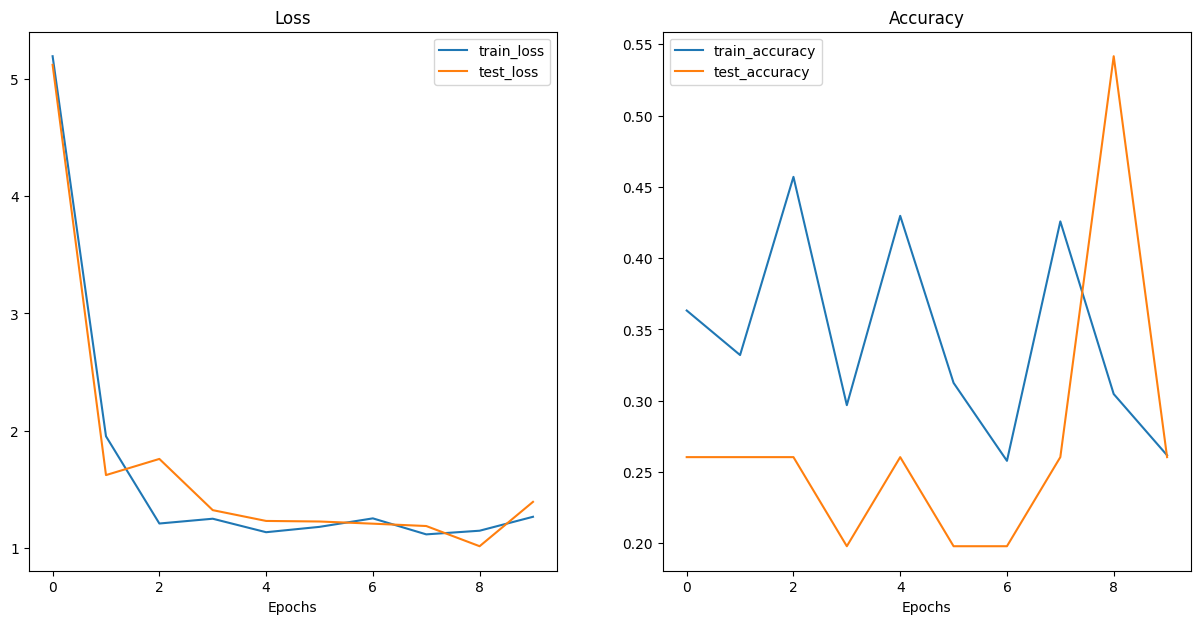

In [51]:
from helper_functions import plot_loss_curves

# Plot our ViT model's loss curves
plot_loss_curves(results)

IT seems like our model is severly underfittin(not achieving the results we'd like it to)

## 10 Using a pretrained ViT troch `torchvision.models` on the same dataset

### 10.1 Why ise a pretrained model?

An important note on many modern machine learning research papers is that much of the results are obtained with large datasets and vast compute resources.

Reading the ViT paper section 4.2:

*Finally, the ViT-L/16 model pre-trained on the public ImageNet-21k dataset performs well on most datasets too, while taking fewer resources to pre-train: it could be trained using a standard cloud TPUv3 with 8 cores in approximately 30 days.*

As of July 2022, the price for renting a TPUv3 (Tensor Processing Unit version 3) with 8 cores on Google Cloud is $8 USD per hour.

To rent one for 30 straight days would cost $5,760 USD.

### 10.2 Getting a pretrained ViT model and creating a feature extractor

In [52]:
# The following requires torch v0.12+ and torchvision v0.13+
import torch
import torchvision
print(torch.__version__)
print(torchvision.__version__)

2.1.0+cu118
0.16.0+cu118


In [53]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

1. Get the pretrained weights for ViT-Base trained on ImageNet-1k from torchvision.models.ViT_B_16_Weights.DEFAULT (DEFAULT stands for best available).
2. Setup a ViT model instance via torchvision.models.vit_b_16, pass it the pretrained weights step 1 and send it to the target device.
3. Freeze all of the parameters in the base ViT model created in step 2 by setting their requires_grad attribute to False.
4. Update the classifier head of the ViT model created in step 2 to suit our own problem by changing the number of out_features to our number of classes (pizza, steak, sushi).

In [54]:
# 1. Get pretrianred weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT

# 2. Setup a ViT model instance with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# 3. Freeze the base parameters
for param in pretrained_vit.parameters():
  param.requires_grad = False

# 4. Change the classifeir head
set_seeds()
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)
pretrained_vit # uncomment for model output

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [55]:
# Print a summary using torchinfo (uncomment for actual output)
summary(model=pretrained_vit,
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 3]              768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

Notice how only the output layer is trainable, where as, all of the rest of the layers are untrainable (frozen).

And the total number of parameters, 85,800,963, is the same as our custom made ViT model above.

But the number of trainable parameters for pretrained_vit is much, much lower than our custom vit at only 2,307 compared to 85,800,963 (in our custom vit, since we're training from scratch, all parameters are trainable).

This means the pretrained model should train a lot faster, we could potentially even use a larger batch size since less parameter updates are going to be taking up memor

### 10.3 Preparing data for the pretrained ViT model

In [56]:
from helper_functions import download_data

# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] data/pizza_steak_sushi directory exists, skipping download.


PosixPath('data/pizza_steak_sushi')

In [57]:
# Setup train and test directory paths
train_dir = image_path / "train"
test_dir = image_path / "test"
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

**ensure your own custom data is transformed/formatted in the same way the data the original model was trained on.**

In [58]:
# Get automatic transforms from pretrained ViT weights
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [59]:
# Setup dataloaders
train_dataloader_pretrained, test_dataloader_pretrained, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                     test_dir=test_dir,
                                                                                                     transform=pretrained_vit_transforms,
                                                                                                     batch_size=32) # Could increase if we had more samples, such as here: https://arxiv.org/abs/2205.01580 (there are other improvements there too...)


### 10.4 Train feature extractor ViT model

In [62]:
from going_modular.going_modular import engine

# Create optimizer and loss function
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of the pretrained ViT feature extractor model
set_seeds()
pretrained_vit_results = engine.train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=10,
                                      device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7663 | train_acc: 0.7188 | test_loss: 0.5435 | test_acc: 0.8769
Epoch: 2 | train_loss: 0.3436 | train_acc: 0.9453 | test_loss: 0.3257 | test_acc: 0.8977
Epoch: 3 | train_loss: 0.2068 | train_acc: 0.9492 | test_loss: 0.2698 | test_acc: 0.9186
Epoch: 4 | train_loss: 0.1557 | train_acc: 0.9609 | test_loss: 0.2414 | test_acc: 0.9186
Epoch: 5 | train_loss: 0.1244 | train_acc: 0.9727 | test_loss: 0.2271 | test_acc: 0.8977
Epoch: 6 | train_loss: 0.1210 | train_acc: 0.9766 | test_loss: 0.2122 | test_acc: 0.9280
Epoch: 7 | train_loss: 0.0933 | train_acc: 0.9766 | test_loss: 0.2342 | test_acc: 0.8883
Epoch: 8 | train_loss: 0.0793 | train_acc: 0.9844 | test_loss: 0.2268 | test_acc: 0.9081
Epoch: 9 | train_loss: 0.1084 | train_acc: 0.9883 | test_loss: 0.2064 | test_acc: 0.9384
Epoch: 10 | train_loss: 0.0646 | train_acc: 0.9922 | test_loss: 0.1795 | test_acc: 0.9176


### 10.5 Plot feature extractor ViT model loss curves

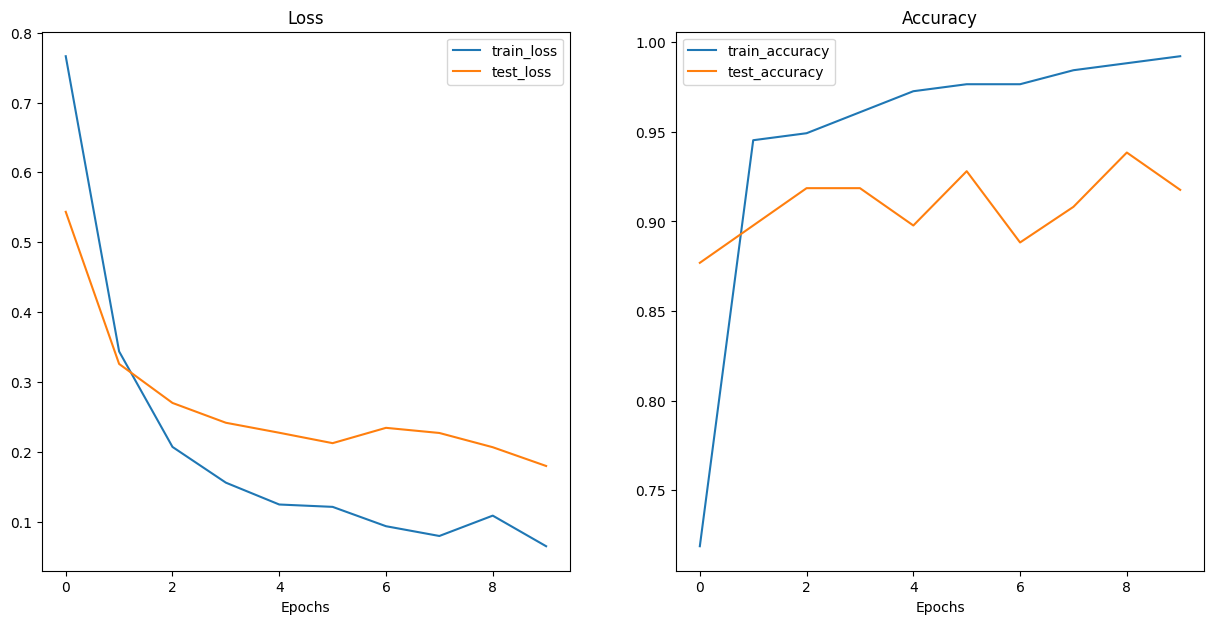

In [63]:
# Plot the loss curves
from helper_functions import plot_loss_curves

plot_loss_curves(pretrained_vit_results)

We managed to get outstanding results with the same model architecture, except our custom implementation was trained from scratch (worse performance) and this feature extractor model has the power of pretrained weights from ImageNet behind it.



### 10.6 Save feature extractor ViT model and check sile size



In [64]:
# Save the model
from going_modular.going_modular import utils

utils.save_model(model=pretrained_vit,
                 target_dir="models",
                 model_name="08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth")

[INFO] Saving model to: models/08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth


And since we're thinking about deploying this model, it'd be good to know the size of it (in megabytes or MB).

Since we want our Food Vision Mini application to run fast, generally a smaller model with good performance will be better than a larger model with great performance.

In [65]:
from pathlib import Path

# Get the model size in bytes then convert to megabytes
pretrained_vit_model_size = Path("models/08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth").stat().st_size // (1024*1024) # division converts bytes to megabytes (roughly)
print(f"Pretrained ViT feature extractor model size: {pretrained_vit_model_size} MB")

Pretrained ViT feature extractor model size: 327 MB


The EffNetB2 model(07_pytorch) is ~11x smaller than the ViT model with similiar results for test loss and accuracy.

But in terms of deployment, if we were comparing these two models, something we'd need to consider is whether the extra accuracy from the ViT model is worth the ~11x increase in model size?





